In [83]:
from PIL import Image
import numpy as np

# Load the image
image_path = "image.jpg"  # Replace with your image path
image = Image.open(image_path)

# Convert the image to a NumPy array
image_array = np.array(image) / 255.0  # Normalize pixel values to the range [0, 1]

# Display shape of the array
print(image_array.shape)


(578, 770, 3)


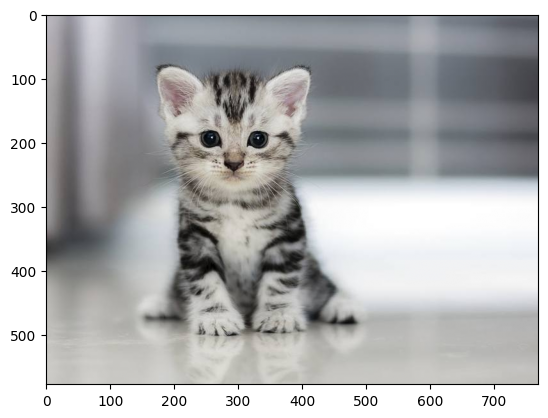

In [64]:
import matplotlib.pyplot as plt
plt.imshow(image_array)

In [71]:
from PIL import Image
import numpy as np
from numpy.linalg import svd
import matplotlib.pyplot as plt

def compress(image_array, k):
    # Split the channels (R, G, B)
    r, g, b = image_array[:, :, 0], image_array[:, :, 1], image_array[:, :, 2]

    # Perform SVD on each channel
    U_r, S_r, Vt_r = svd(r, full_matrices=False)
    U_g, S_g, Vt_g = svd(g, full_matrices=False)
    U_b, S_b, Vt_b = svd(b, full_matrices=False)

    # Print out the shapes of the decomposed components
    print("Red channel: ", U_r.shape, S_r.shape, Vt_r.shape)
    print("Green channel: ", U_g.shape, S_g.shape, Vt_g.shape)
    print("Blue channel: ", U_b.shape, S_b.shape, Vt_b.shape)

    # You can also reconstruct the image using a limited number of singular values
    # For example, keeping the first 50 singular values

    r_approx = U_r[:, :k] @ np.diag(S_r[:k]) @ Vt_r[:k, :]
    g_approx = U_g[:, :k] @ np.diag(S_g[:k]) @ Vt_g[:k, :]
    b_approx = U_b[:, :k] @ np.diag(S_b[:k]) @ Vt_b[:k, :]

    # Stack the channels back to form the compressed image
    image_approx = np.stack((r_approx, g_approx, b_approx), axis=2)

    # Clip values to ensure they remain in valid pixel range [0, 1]
    image_approx = np.clip(image_approx, 0, 1)
    return image_approx

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct

def apply_dct_2d(channel):
    """Apply 2D Discrete Cosine Transform (DCT) to an image channel."""
    return dct(dct(channel.T, norm='ortho').T, norm='ortho')

def apply_idct_2d(channel_dct):
    """Apply 2D Inverse Discrete Cosine Transform (IDCT) to a DCT-transformed channel."""
    return idct(idct(channel_dct.T, norm='ortho').T, norm='ortho')


def compress_dct(image_array, k):
    """
    Compress an image using DCT, keeping the top k DCT coefficients for each channel.

    Parameters:
    - image_array: Input image as a NumPy array.
    - k: Number of DCT coefficients to retain.

    Returns:
    - Compressed image after inverse DCT.
    """
    # If RGB, split channels (R, G, B)
    if len(image_array.shape) == 3:
        r, g, b = image_array[:, :, 0], image_array[:, :, 1], image_array[:, :, 2]

        # Apply DCT to each channel
        r_dct = apply_dct_2d(r)
        g_dct = apply_dct_2d(g)
        b_dct = apply_dct_2d(b)

        # Zero out all but the top k coefficients (retaining low-frequency components)
        r_dct[k:, k:] = 0
        g_dct[k:, k:] = 0
        b_dct[k:, k:] = 0

        # Reconstruct the image using inverse DCT
        r_compressed = apply_idct_2d(r_dct)
        g_compressed = apply_idct_2d(g_dct)
        b_compressed = apply_idct_2d(b_dct)

        # Stack the channels back together
        image_compressed = np.stack((r_compressed, g_compressed, b_compressed), axis=2)

    else:
        # For grayscale images, apply DCT
        channel_dct = apply_dct_2d(image_array)

        # Zero out all but the top k coefficients
        channel_dct[k:, k:] = 0

        # Reconstruct the image using inverse DCT
        image_compressed = apply_idct_2d(channel_dct)

    # Clip values to ensure they remain in valid pixel range [0, 255]
    image_compressed = np.clip(image_compressed, 0, 1)

    return image_compressed

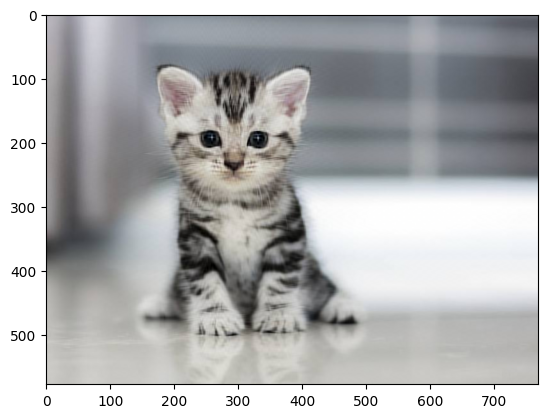

In [87]:
k = 100
plt.imshow(compress_dct(image_array, k))

In [76]:
import numpy as np
import math

def calculate_psnr(original, approx):
    # Ensure the inputs are of the same shape and type
    assert original.shape == approx.shape, "Original and approximated images must have the same shape."

    # Compute the Mean Squared Error (MSE)
    mse = np.mean((original - approx) ** 2)

    # If MSE is zero, return infinity (the images are identical)
    if mse == 0:
        return float('inf')

    # Maximum pixel value for 8-bit images is 255
    max_pixel_value = 255.0
    psnr = 10 * math.log10((max_pixel_value ** 2) / mse)

    return psnr

def calculate_mse(original, approx):
    """
    Calculate Mean Squared Error (MSE) between two images.

    Parameters:
    - original: The original image as a NumPy array.
    - approx: The approximated image as a NumPy array.

    Returns:
    - mse: The Mean Squared Error between the two images.
    """
    # Ensure the images have the same shape
    assert original.shape == approx.shape, "Original and approximated images must have the same shape."

    # Calculate MSE
    mse = np.mean((original - approx) ** 2)

    return mse

# Calculate PSNR between original and approximated image
psnr_value = calculate_psnr(image_array, image_approx)

print(f"PSNR: {psnr_value:.2f} dB")


PSNR: 3.54 dB


In [77]:
ks_dct = np.arange(25,500,5)
psnrs_dct = []
ratios_dct = []
mses_dct = []
for k in ks_dct:
    image_approx = compress_dct(image_array, k)
    psnr_value = calculate_psnr(image_array, image_approx)
    psnrs_dct.append(psnr_value)
    mses_dct.append(calculate_mse(image_array, image_approx))
    m, n = image_array.shape[:2]
    ratio = float(m * n) / float(k * k)
    ratios_dct.append(ratio)

In [78]:
ks = np.arange(5,100,5)
psnrs = []
ratios = []
mses = []
for k in ks:
    image_approx = compress(image_array, k)
    psnr_value = calculate_psnr(image_array, image_approx)
    psnrs.append(psnr_value)
    m, n = image_array.shape[:2]
    ratio = float(m * n) / float(k * (1 + m + n))
    mses.append(calculate_mse(image_array, image_approx))
    ratios.append(ratio)

Red channel:  (578, 578) (578,) (578, 770)
Green channel:  (578, 578) (578,) (578, 770)
Blue channel:  (578, 578) (578,) (578, 770)
Red channel:  (578, 578) (578,) (578, 770)
Green channel:  (578, 578) (578,) (578, 770)
Blue channel:  (578, 578) (578,) (578, 770)
Red channel:  (578, 578) (578,) (578, 770)
Green channel:  (578, 578) (578,) (578, 770)
Blue channel:  (578, 578) (578,) (578, 770)
Red channel:  (578, 578) (578,) (578, 770)
Green channel:  (578, 578) (578,) (578, 770)
Blue channel:  (578, 578) (578,) (578, 770)
Red channel:  (578, 578) (578,) (578, 770)
Green channel:  (578, 578) (578,) (578, 770)
Blue channel:  (578, 578) (578,) (578, 770)
Red channel:  (578, 578) (578,) (578, 770)
Green channel:  (578, 578) (578,) (578, 770)
Blue channel:  (578, 578) (578,) (578, 770)
Red channel:  (578, 578) (578,) (578, 770)
Green channel:  (578, 578) (578,) (578, 770)
Blue channel:  (578, 578) (578,) (578, 770)
Red channel:  (578, 578) (578,) (578, 770)
Green channel:  (578, 578) (578,)

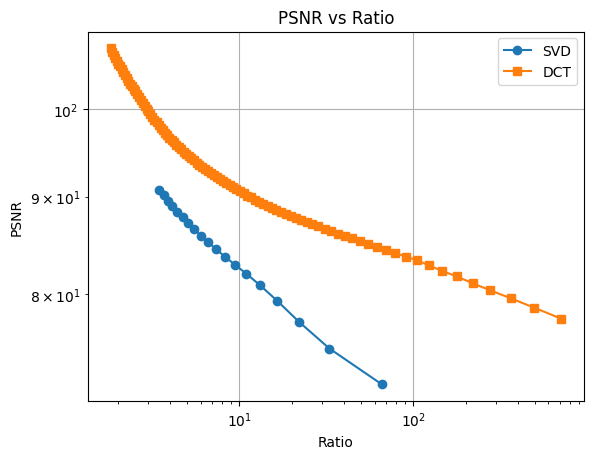

In [79]:
plt.plot(ratios, psnrs, marker='o', label='SVD')
plt.plot(ratios_dct, psnrs_dct, marker='s', label='DCT')
plt.xlabel('Ratio')
plt.ylabel('PSNR')
plt.title('PSNR vs Ratio')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()


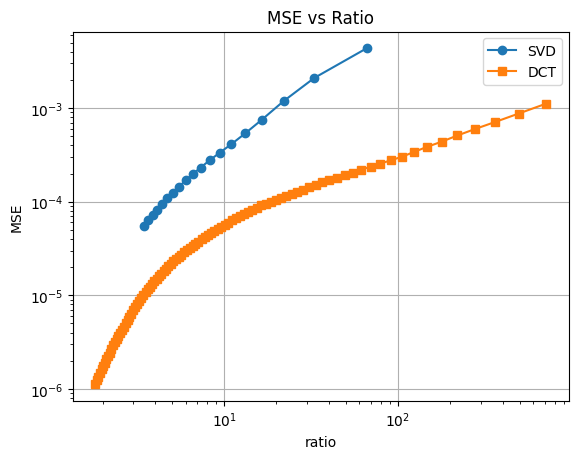

In [81]:
plt.plot(ratios, mses, marker='o', label='SVD')
plt.plot(ratios_dct, mses_dct, marker='s', label='DCT')
plt.xlabel('ratio')
plt.ylabel('MSE')
plt.title('MSE vs Ratio')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()